# ScRNA-Seq of human bone marrow cells from Oetjen et al.

Inspired by the work of [Luecken, MD. et al.](https://www.nature.com/articles/s41592-021-01336-8#Sec35)
<br>Code: https://github.com/theislab/scib-reproducibility/tree/main 
<br>
<br>Data from [Oetjen, KA. et al.](https://insight.jci.org/articles/view/124928)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396176 

In [14]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [15]:
# Path of data
file_base = '../../../../../data/raw/immune_cells/bone_marrow_human/GSM3396176_P/'
count_file_end = 'GSM3396176_matrix_P.mtx.gz'
gene_data_end = 'GSM3396176_genes_P.tsv.gz'
barcode_data_end = 'GSM3396176_barcodes_P.tsv.gz'

count_data = file_base+count_file_end
gene_data = file_base+gene_data_end
barcode_data = file_base+barcode_data_end

# Read data
adata = dp.read_sc_data(count_data, gene_data, barcode_data)

adata.var_names_make_unique()

In [16]:
print(adata.X.shape)
print(adata)

(3383, 33694)
AnnData object with n_obs × n_vars = 3383 × 33694
    var: 'gene_id'


In [17]:
adata.var.head()

,gene_id
gene_symbol,
RP11-34P13.3,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


## Metadata from [Oetjen, KA. et al.](https://insight.jci.org/articles/view/124928)

In [18]:
adata.obs["patient"] = "BM_2"
adata.obs["tissue"] = "bone marrow"
adata.obs["age"] = 58
adata.obs["health_condition"] = "healthy"
adata.obs["method"] = "Droplet-based scRNAseq"
adata.obs["instrument"] = "Illumina HiSeq 3000"

## Preprocessing

In [19]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                   patient       tissue  age health_condition  \
barcode                                                         
AAACCTGAGAGAGCTC-1    BM_2  bone marrow   58          healthy   
AAACCTGAGGCAAAGA-1    BM_2  bone marrow   58          healthy   
AAACCTGCACGAGGTA-1    BM_2  bone marrow   58          healthy   
AAACCTGGTCCGAATT-1    BM_2  bone marrow   58          healthy   
AAACCTGTCCTAAGTG-1    BM_2  bone marrow   58          healthy   
...                    ...          ...  ...              ...   
TTTGTCAAGCTGCGAA-1    BM_2  bone marrow   58          healthy   
TTTGTCAAGTTAGCGG-1    BM_2  bone marrow   58          healthy   
TTTGTCAGTTCCCTTG-1    BM_2  bone marrow   58          healthy   
TTTGTCATCGTCCAGG-1    BM_2  bone marrow   58          healthy   
TTTGTCATCTGGAGCC-1    BM_2  bone marrow   58          healthy   

                                    method           instrument  n_counts  \
barcode                                                                     


In [20]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,3,5])

Number of cells before QC filtering: 3383
Number of cells removed by log_n_genes filtering: 9
Number of cells removed by log_n_counts filtering: 11
Number of cells removed by pct_counts_in_top_20_genes filtering: 1251
Number of cells removed by mt_frac filtering: 5
Number of cells post QC filtering: 2115
Number of genes before filtering: 33694
Number of genes after filtering so theres min 20 unique cells per gene: 12775


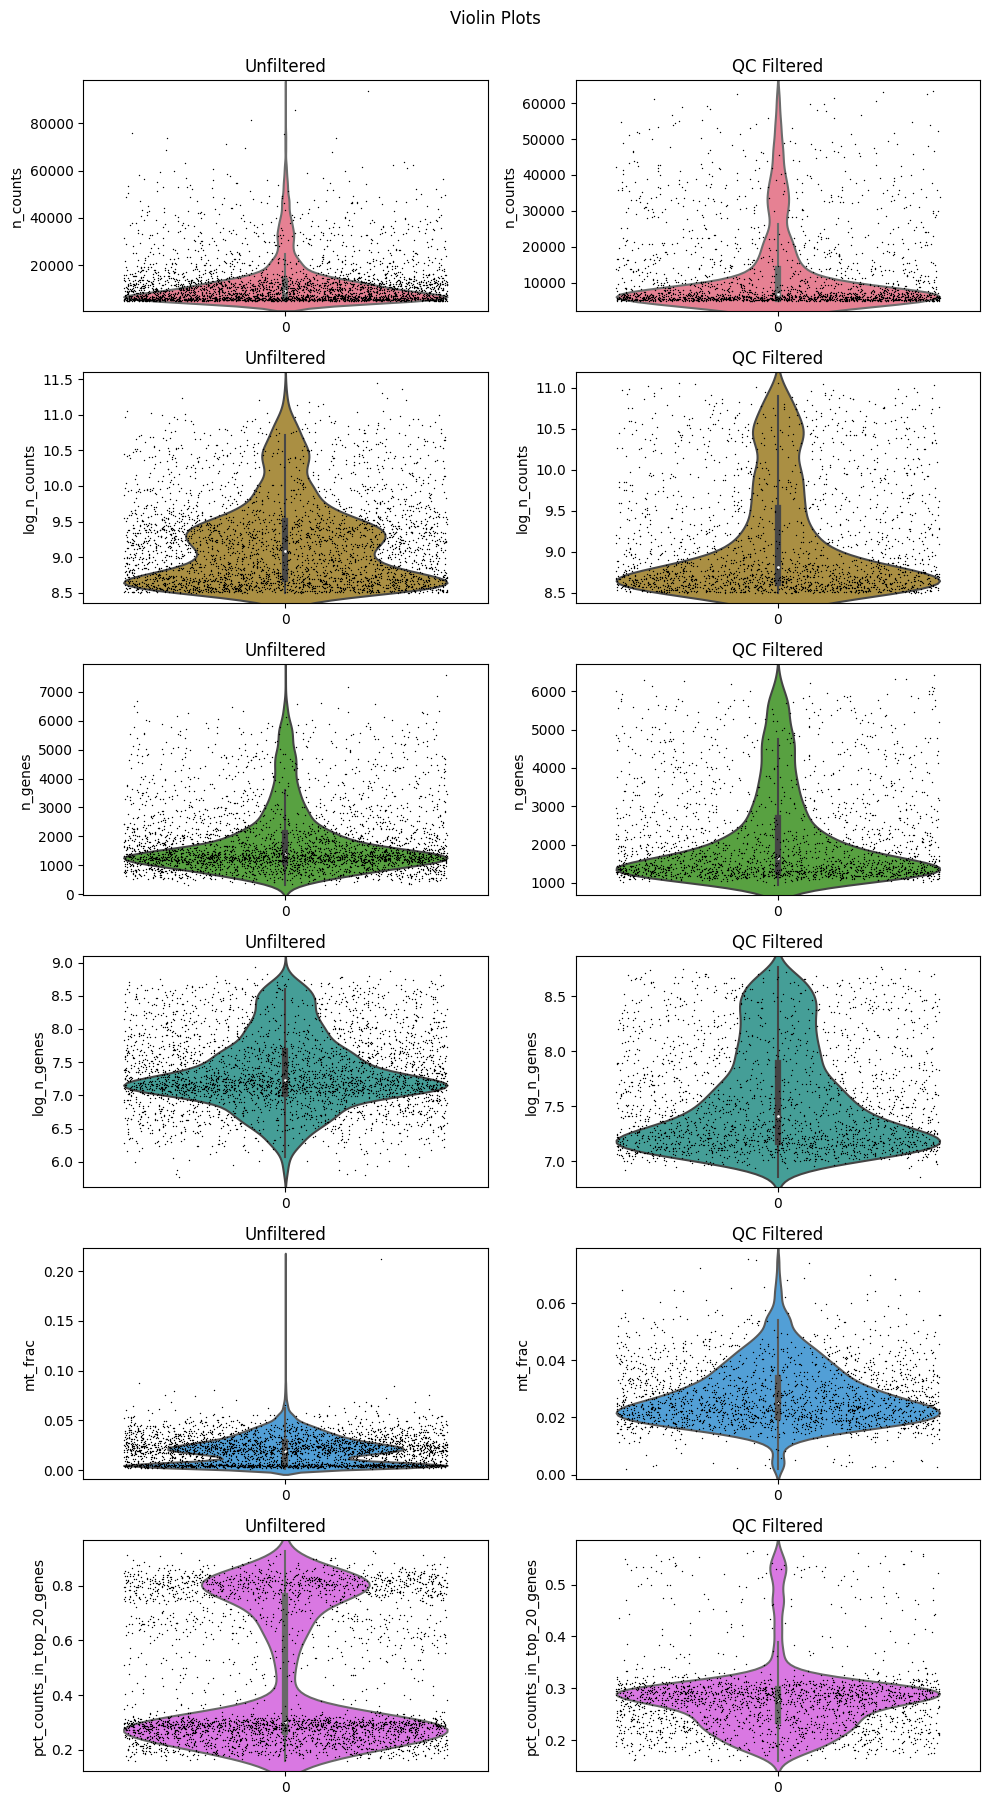

In [21]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

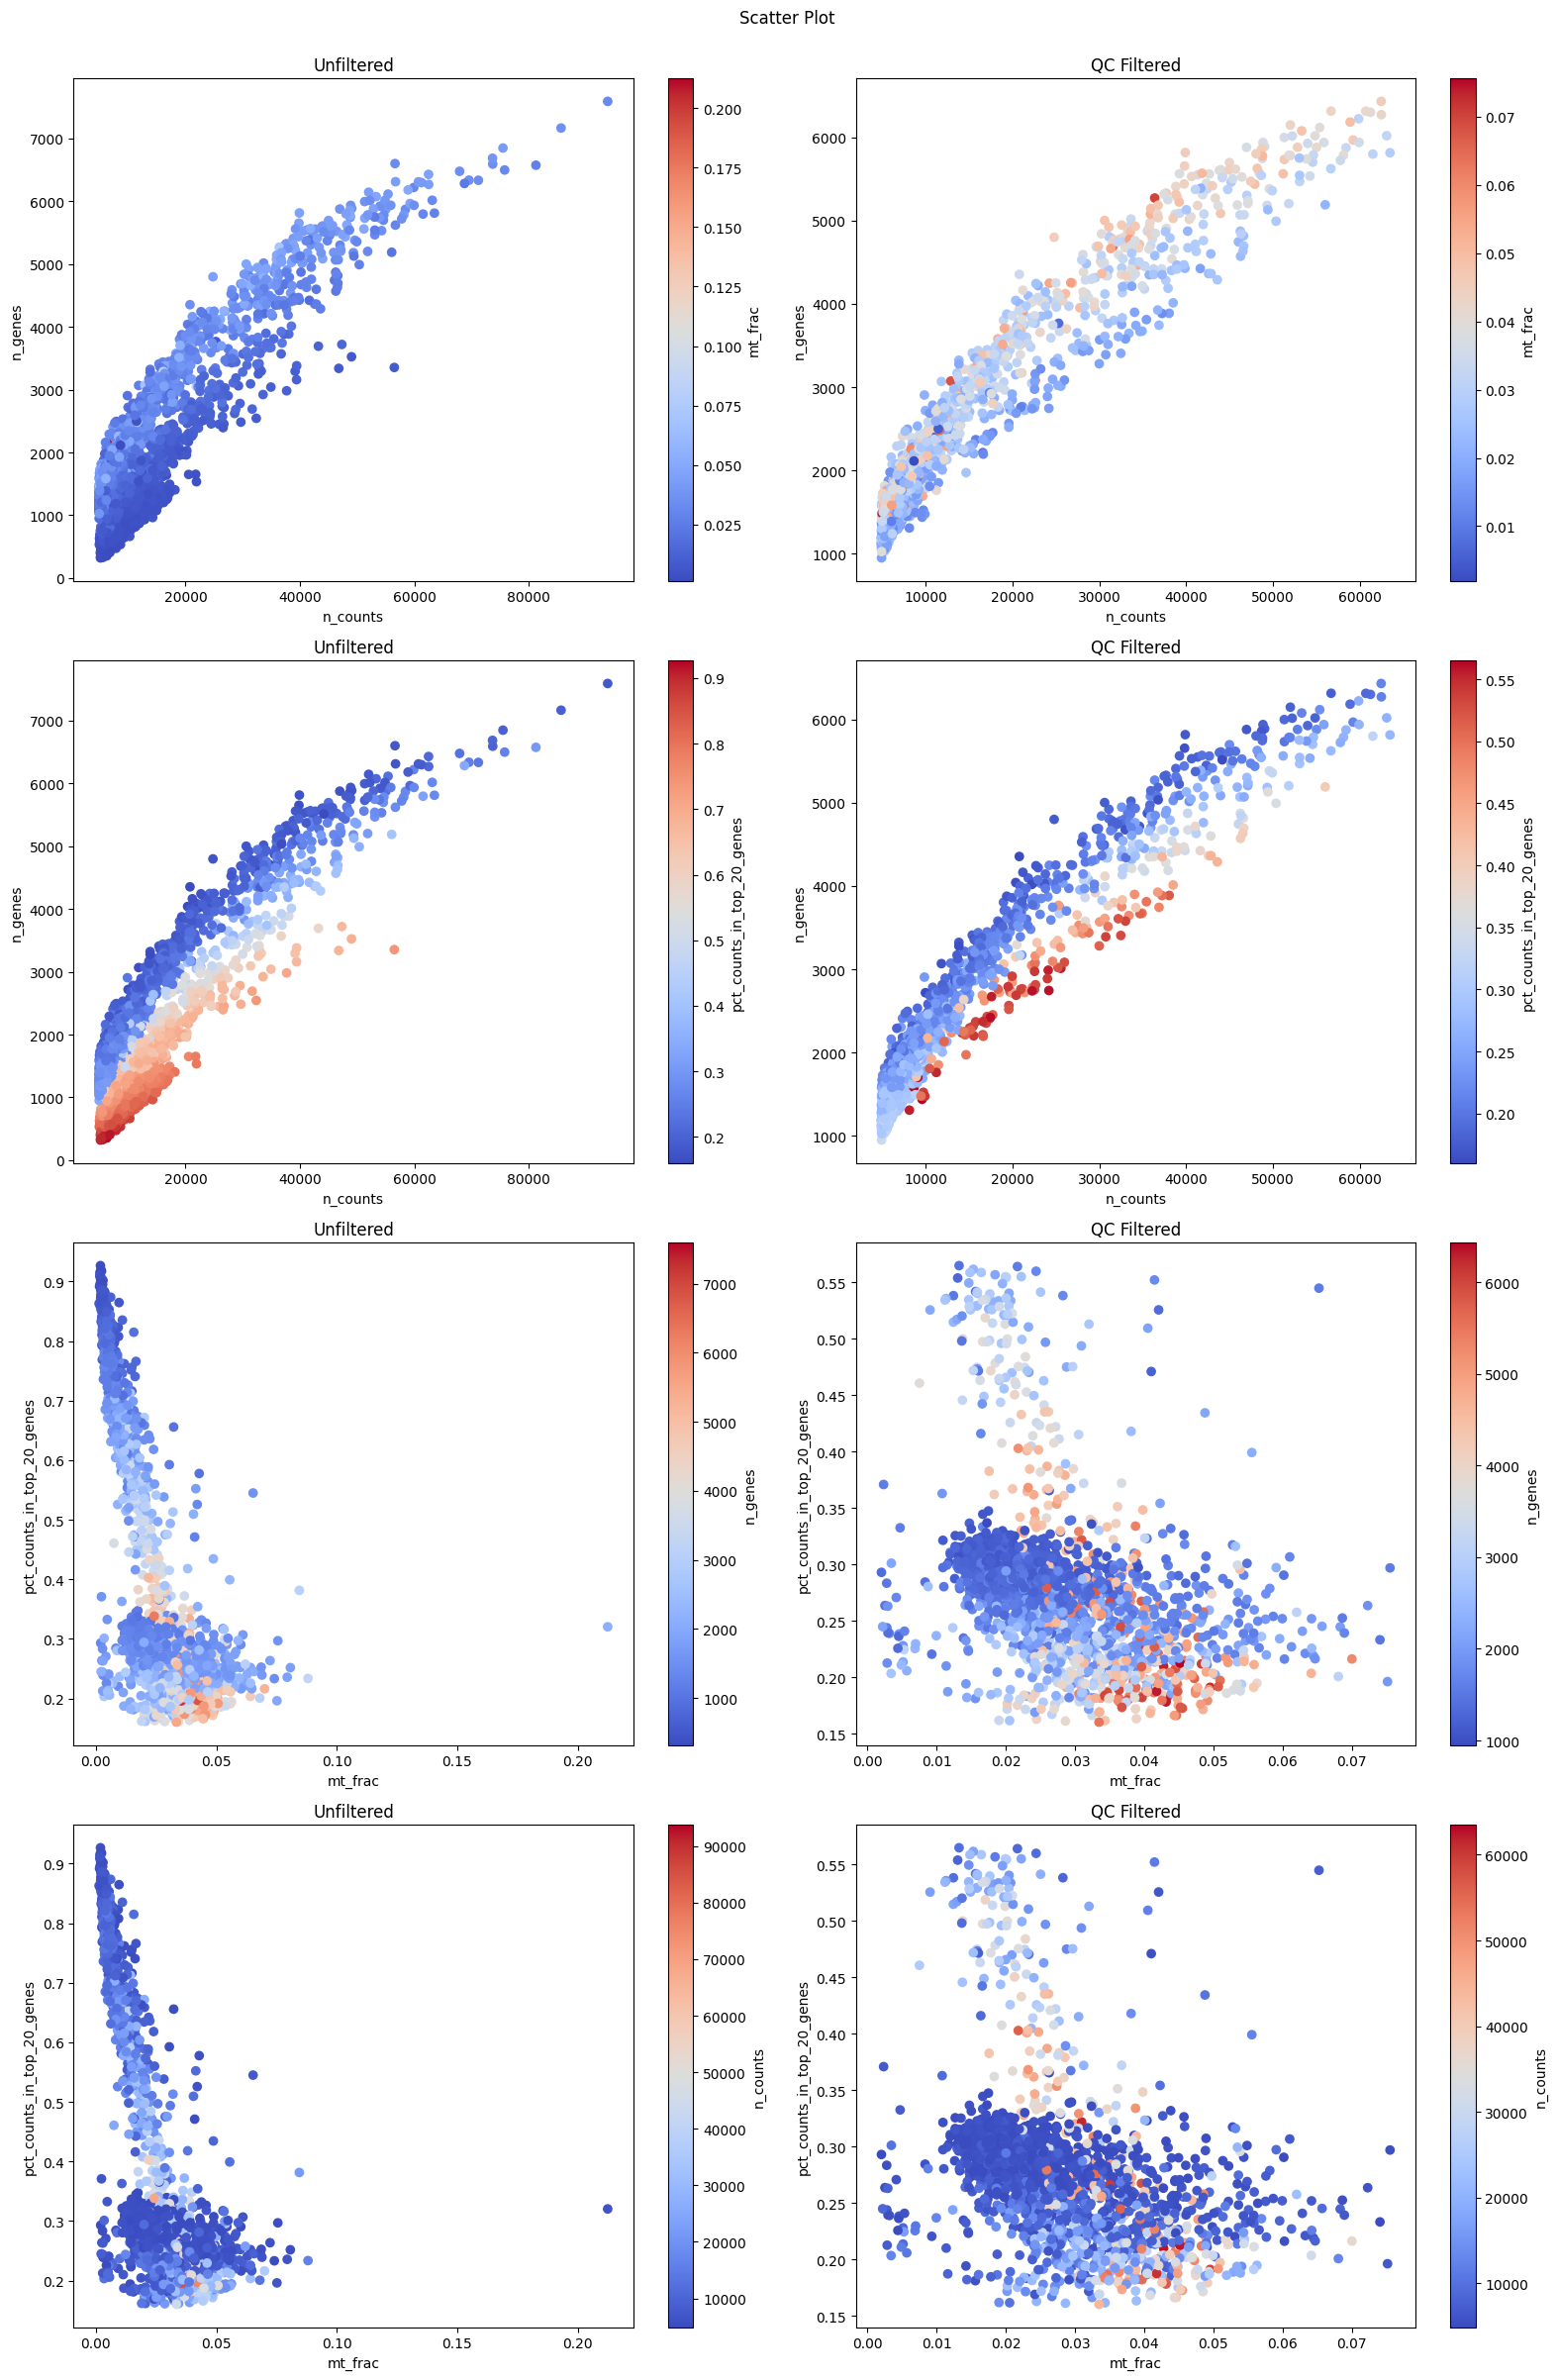

In [22]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [23]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [24]:
norm_qc_adata

AnnData object with n_obs × n_vars = 2115 × 12775
    obs: 'patient', 'tissue', 'age', 'health_condition', 'method', 'instrument', 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'outlier', 'size_factors'
    var: 'gene_id', 'n_cells'
    layers: 'counts', 'log1p_counts'

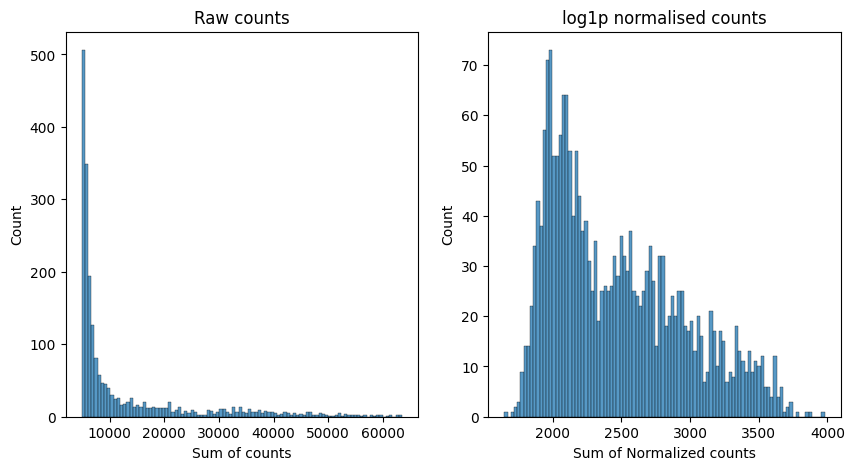

In [25]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [26]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("BM_2.csv")
norm_qc_adata.write("BM_2_adata.h5ad")